# Analyze Ithaca Air Quality Data
[J. Nathan Matias](https://natematias.com), March 2021

In [1]:
import csv, sys, os, random, math
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import numpy as np
import statsmodels as sm
import statsmodels.formula.api as smf
from collections import defaultdict, Counter
from dateutil import parser
import seaborn as sns
import pandas as pd

## Load Data

In [2]:
middle_low = {}
with open("data/03.28.2021-middle-low.csv") as f:
    for row in csv.DictReader(f):
        for col in ['temperature[degF]', 'humidity[%]', 
                    'co2[ppm]', 'pm1.0[ug/m^3]', 
                    'pm2.5[ug/m^3]', 'pm10.0[ug/m^3]', 
                    'pressure[Pa]', 'altitude[m]', 
                    'aqi', 'nowcast', 'heatindex[degF]']:
            if row[col] is None or row[col] in ['---','']:
                row[col]  = None
            else:
                row[col] = float(row[col])
        timestamp = parser.parse(row['timestamp'])
        row['timestamp'] = timestamp
        middle_low[timestamp] = row
        
east_high = {}
with open("data/03.28.2021-east-high.csv") as f:
    for row in csv.DictReader(f):
        for col in ['temperature[degF]', 'humidity[%]', 
                    'co2[ppm]', 'pm1.0[ug/m^3]', 
                    'pm2.5[ug/m^3]', 'pm10.0[ug/m^3]', 
                    'pressure[Pa]', 'altitude[m]', 
                    'aqi', 'nowcast', 'heatindex[degF]']:
            if row[col] is None or row[col] in ['---','']:
                row[col]  = None
            else:
                row[col] = float(row[col])
        timestamp = parser.parse(row['timestamp'])
        row['timestamp'] = timestamp
        east_high[timestamp] = row
        
west_high = {}
with open("data/03.28.2021-west-high.csv") as f:
    for row in csv.DictReader(f):
        for col in ['temperature[degF]', 'humidity[%]', 
                    'co2[ppm]', 'pm1.0[ug/m^3]', 
                    'pm2.5[ug/m^3]', 'pm10.0[ug/m^3]', 
                    'pressure[Pa]', 'altitude[m]', 
                    'aqi', 'nowcast', 'heatindex[degF]']:
            if row[col] is None or row[col] in ['---','']:
                row[col]  = None
            else:
                row[col] = float(row[col])
        timestamp = parser.parse(row['timestamp'])
        row['timestamp'] = timestamp
        west_high[timestamp] = row
        

In [3]:
cayuga_lake_wind = {}
with open("data/CayugaLake_2021YTD_MeanWind.csv") as f:
    for row in csv.DictReader(f):
        timestamp = parser.parse(row['Timestamp'])
        for col in row.keys():
            if col in ['WS_ms__Avg','WindDir_Deg']:
                row[col] = float(row[col])
        cayuga_lake_wind[timestamp] = row

## Generate Secondary Variables

In [4]:
earliest_date = min([x for x in middle_low.keys()])
for row in middle_low.values():
    row['seconds_since_earliest'] = (row['timestamp'] - earliest_date).total_seconds()
for row in east_high.values():
    row['seconds_since_earliest'] = (row['timestamp'] - earliest_date).total_seconds()
for row in west_high.values():
    row['seconds_since_earliest'] = (row['timestamp'] - earliest_date).total_seconds()

In [5]:
print("Earliest date: {0}".format(earliest_date))
print("Latest date: {0}".format(max([x for x in middle_low.keys()])))

Earliest date: 2021-02-12 22:01:42
Latest date: 2021-03-23 23:58:07


In [6]:
prev_date = earliest_date
for item in sorted(middle_low.items(), key = lambda x: x[0]):
    row = item[1]
    row['seconds_since_last'] = (row['timestamp'] - prev_date).total_seconds()
    prev_date = row['timestamp']
    
prev_date = earliest_date
for item in sorted(east_high.items(), key = lambda x: x[0]):
    row = item[1]
    row['seconds_since_last'] = (row['timestamp'] - prev_date).total_seconds()
    prev_date = row['timestamp']
  
prev_date = earliest_date
for item in sorted(west_high.items(), key = lambda x: x[0]):
    row = item[1]
    row['seconds_since_last'] = (row['timestamp'] - prev_date).total_seconds()
    prev_date = row['timestamp']

In [7]:
#Counter([x['timestamp'].date() for x in middle_low.values()])
#Counter([x.date() for x in middle_low.keys()])
#Counter([x.date() for x in middle_keys])

## Generate Merged Dataset

In [8]:
## sort keys by timestamp
middle_keys = sorted(middle_low.keys(), key = lambda x: x)
east_keys = sorted(east_high.keys(), key = lambda x: x)
west_keys = sorted(west_high.keys(), key = lambda x: x)
wind_keys = sorted(cayuga_lake_wind.keys(), key = lambda x: x)

In [9]:
merged_measurements = {}
counter = 0

for timestamp, row in middle_low.items():
    new_row = {}
    
    ## assign middle_low values to the row
    for key in row.keys():
        new_row['middle_' + key] = row[key]
    
    ## find the most recent east_high row
    east_timestamp = east_keys[0]
    for t in east_keys:
        if east_timestamp > timestamp:
            break
        east_timestamp = t
    
    ## assign those values to the new row
    east_row = east_high[east_timestamp]
    for key in east_row.keys():
        new_row['east_' + key] = east_row[key]
    new_row['seconds_since_east'] = (timestamp - east_timestamp).total_seconds()
        

    ## find the most recent west_high row
    west_timestamp = west_keys[0]
    for t in west_keys:
        if west_timestamp > timestamp:
            break
        west_timestamp = t
    
    ## assign those values to the new row
    west_row = west_high[west_timestamp]
    for key in west_row.keys():
        new_row['west_' + key] = west_row[key]
    new_row['seconds_since_west'] = (timestamp - west_timestamp).total_seconds()
    
    
    ## find the most recent wind measurement row
    wind_timestamp = wind_keys[0]
    for t in wind_keys:
        if wind_timestamp > timestamp:
            break
        wind_timestamp = t
        
    ## assign those values to the new row
    wind_row = cayuga_lake_wind[wind_timestamp]
    for key in wind_row.keys():
        new_row['wind_' + key] = wind_row[key]
    new_row['seconds_since_wind'] = (timestamp - wind_timestamp).total_seconds()
    
    merged_measurements[timestamp] = new_row
    
    counter += 1
    if(counter % 100 == 0):
        sys.stdout.write(".")
        sys.stdout.flush()

....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [10]:
#Counter([x['middle_timestamp'].date() for x in merged_measurements.values()])
Counter([x['middle_timestamp'].date() for x in merged_measurements.values() if x['middle_aqi'] is not None])

#[x for x in merged_measurements.values() if x['middle_timestamp'].date() == parser.parse("2021-03-18")]

Counter({datetime.date(2021, 2, 12): 12,
         datetime.date(2021, 2, 13): 144,
         datetime.date(2021, 2, 14): 143,
         datetime.date(2021, 2, 15): 144,
         datetime.date(2021, 2, 16): 144,
         datetime.date(2021, 2, 17): 144,
         datetime.date(2021, 2, 18): 145,
         datetime.date(2021, 2, 19): 143,
         datetime.date(2021, 2, 20): 144,
         datetime.date(2021, 2, 21): 145,
         datetime.date(2021, 2, 22): 143,
         datetime.date(2021, 2, 23): 145,
         datetime.date(2021, 2, 24): 143,
         datetime.date(2021, 2, 25): 144,
         datetime.date(2021, 2, 26): 145,
         datetime.date(2021, 2, 27): 143,
         datetime.date(2021, 2, 28): 145,
         datetime.date(2021, 3, 1): 143,
         datetime.date(2021, 3, 2): 144,
         datetime.date(2021, 3, 3): 144,
         datetime.date(2021, 3, 4): 144,
         datetime.date(2021, 3, 5): 144,
         datetime.date(2021, 3, 6): 145,
         datetime.date(2021, 3, 7): 143,


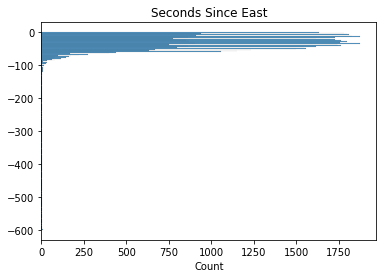

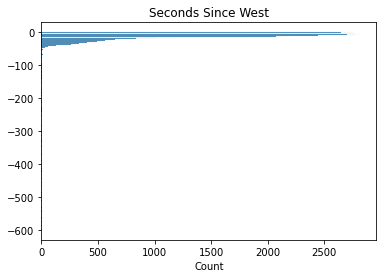

In [11]:
sns.histplot(y=[x['seconds_since_east'] for x in merged_measurements.values()])
plt.title("Seconds Since East")
plt.show()

sns.histplot(y=[x['seconds_since_west'] for x in merged_measurements.values()])
plt.title("Seconds Since West")
plt.show()

In [12]:
list(merged_measurements.values())[0]

{'middle_timestamp': datetime.datetime(2021, 2, 12, 22, 1, 42),
 'middle_temperature[degF]': 18.914,
 'middle_humidity[%]': 44.41,
 'middle_co2[ppm]': 700.0,
 'middle_pm1.0[ug/m^3]': 1.5,
 'middle_pm2.5[ug/m^3]': 2.0,
 'middle_pm10.0[ug/m^3]': 3.0,
 'middle_pressure[Pa]': 101573.0,
 'middle_altitude[m]': 115.5,
 'middle_aqi': None,
 'middle_nowcast': None,
 'middle_heatindex[degF]': 18.0,
 'middle_seconds_since_earliest': 0.0,
 'middle_seconds_since_last': 0.0,
 'east_timestamp': datetime.datetime(2021, 2, 12, 22, 2, 31),
 'east_temperature[degF]': 27.32,
 'east_humidity[%]': 40.94,
 'east_co2[ppm]': 433.0,
 'east_pm1.0[ug/m^3]': 4.6,
 'east_pm2.5[ug/m^3]': 7.4,
 'east_pm10.0[ug/m^3]': 8.0,
 'east_pressure[Pa]': 99674.7,
 'east_altitude[m]': 258.2,
 'east_aqi': None,
 'east_nowcast': None,
 'east_heatindex[degF]': 27.0,
 'east_seconds_since_earliest': 49.0,
 'east_seconds_since_last': 61.0,
 'seconds_since_east': -49.0,
 'west_timestamp': datetime.datetime(2021, 2, 12, 22, 2, 6),
 'wes

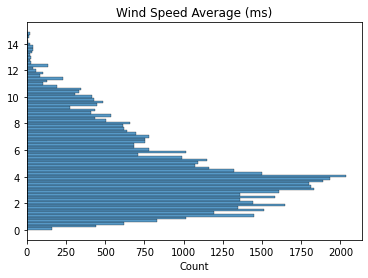

In [13]:
sns.histplot(y=[x['wind_WS_ms__Avg'] for x in merged_measurements.values()])
plt.title("Wind Speed Average (ms)")
plt.show()

## Generate Secondary Variables from Merged Data

In [14]:
for row in merged_measurements.values():
    # temperature differences
    if row['middle_temperature[degF]'] is not None and row['east_temperature[degF]'] is not None and row['west_temperature[degF]'] is not None:        
        ## this is probably a bad measure meteorologically, but it provides
        ## the difference between low_middle and the mean of the higher temps
        row['naive_temp_diff'] = row['middle_temperature[degF]'] - np.mean([row['east_temperature[degF]'], row['west_temperature[degF]']])
        
        ## let's call it an inversion if the temperature diff is less than -3 ?
        ## I have absolutely no basis for this cutoff, since I know nothing about
        ## the phenomenon or the measurement error at play
        row['naive_inversion'] = row['naive_temp_diff'] < -3
    else:
        row['naive_inversion'] = None
        row['naive_temp_diff'] = None
        
    ## air quality differences
    if row['middle_aqi'] is not None and row['west_aqi'] is not None:
        row['middle_west_aqi_diff'] = row['middle_aqi'] - row['west_aqi']
    else:
        row['middle_west_aqi_diff'] = None
    
    row['middle_hour'] = row['middle_timestamp'].hour

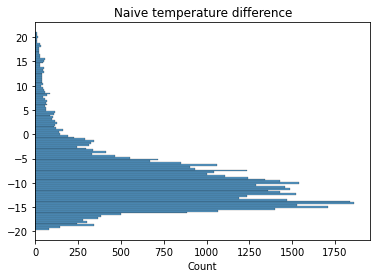

In [15]:
sns.histplot(y=[x['naive_temp_diff'] for x in merged_measurements.values()])
plt.title("Naive temperature difference")
plt.show()

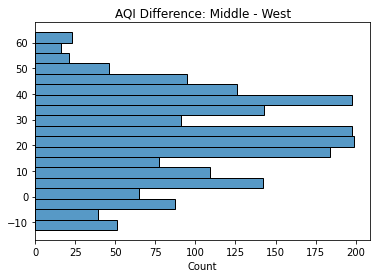

In [16]:
sns.histplot(y=[x['middle_west_aqi_diff'] for x in merged_measurements.values()])
plt.title("AQI Difference: Middle - West")
plt.show()

In [17]:
Counter([x['naive_inversion'] for x in merged_measurements.values()])

Counter({True: 42649, None: 5211, False: 5375})

In [18]:
Counter([x['middle_aqi']>30 for x in merged_measurements.values() if x['middle_aqi'] is not None])

Counter({False: 2718, True: 2905})

## A Few Summary Plots

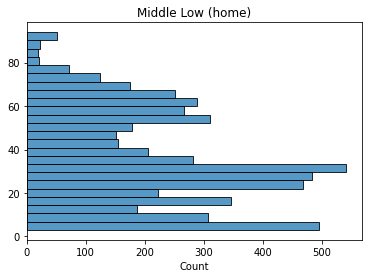

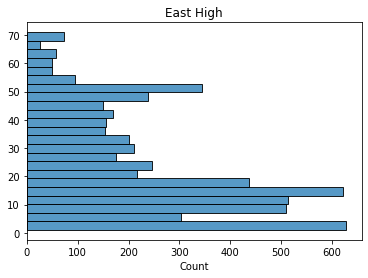

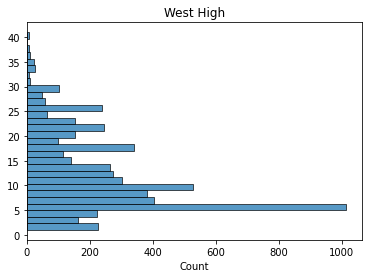

In [19]:
sns.histplot(y=[x['aqi'] for x in middle_low.values() if x['aqi'] is not None])
plt.title("Middle Low (home)")
plt.show()
sns.histplot(y=[x['aqi'] for x in east_high.values() if x['aqi'] is not None])
plt.title("East High")
plt.show()
sns.histplot(y=[x['aqi'] for x in west_high.values() if x['aqi'] is not None])
plt.title("West High")
plt.show()

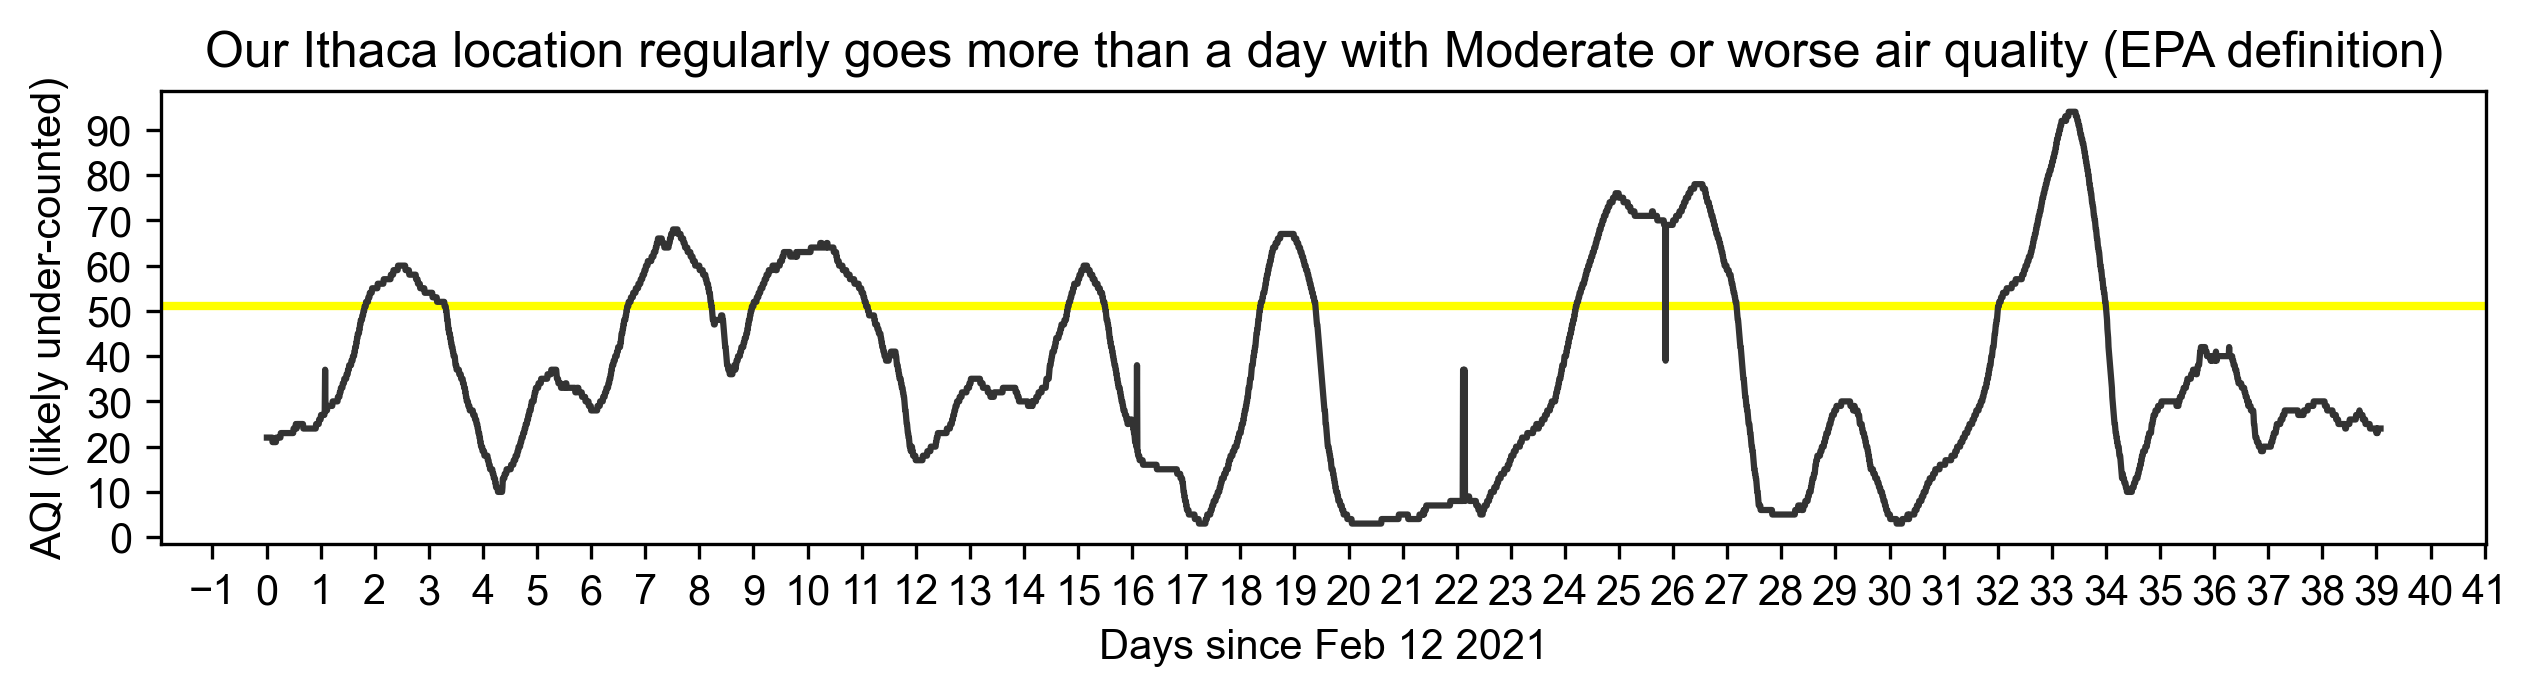

In [20]:
plt.figure(figsize=(10,2), dpi=300)
plt.axhline(y=51, color="#ffff00", linewidth=2)
ax = sns.lineplot(y=[x['aqi'] for x in middle_low.values() if x['aqi'] is not None],
                  x=[x['seconds_since_earliest']/86400 for x in middle_low.values() if x['aqi'] is not None], 
                 color="#333333")
sns.set_theme()
sns.set_style("whitegrid")
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(10))

plt.title("Our Ithaca location regularly goes more than a day with Moderate or worse air quality (EPA definition)")
plt.ylabel("AQI (likely under-counted)")
plt.xlabel("Days since Feb 12 2021")
plt.show()

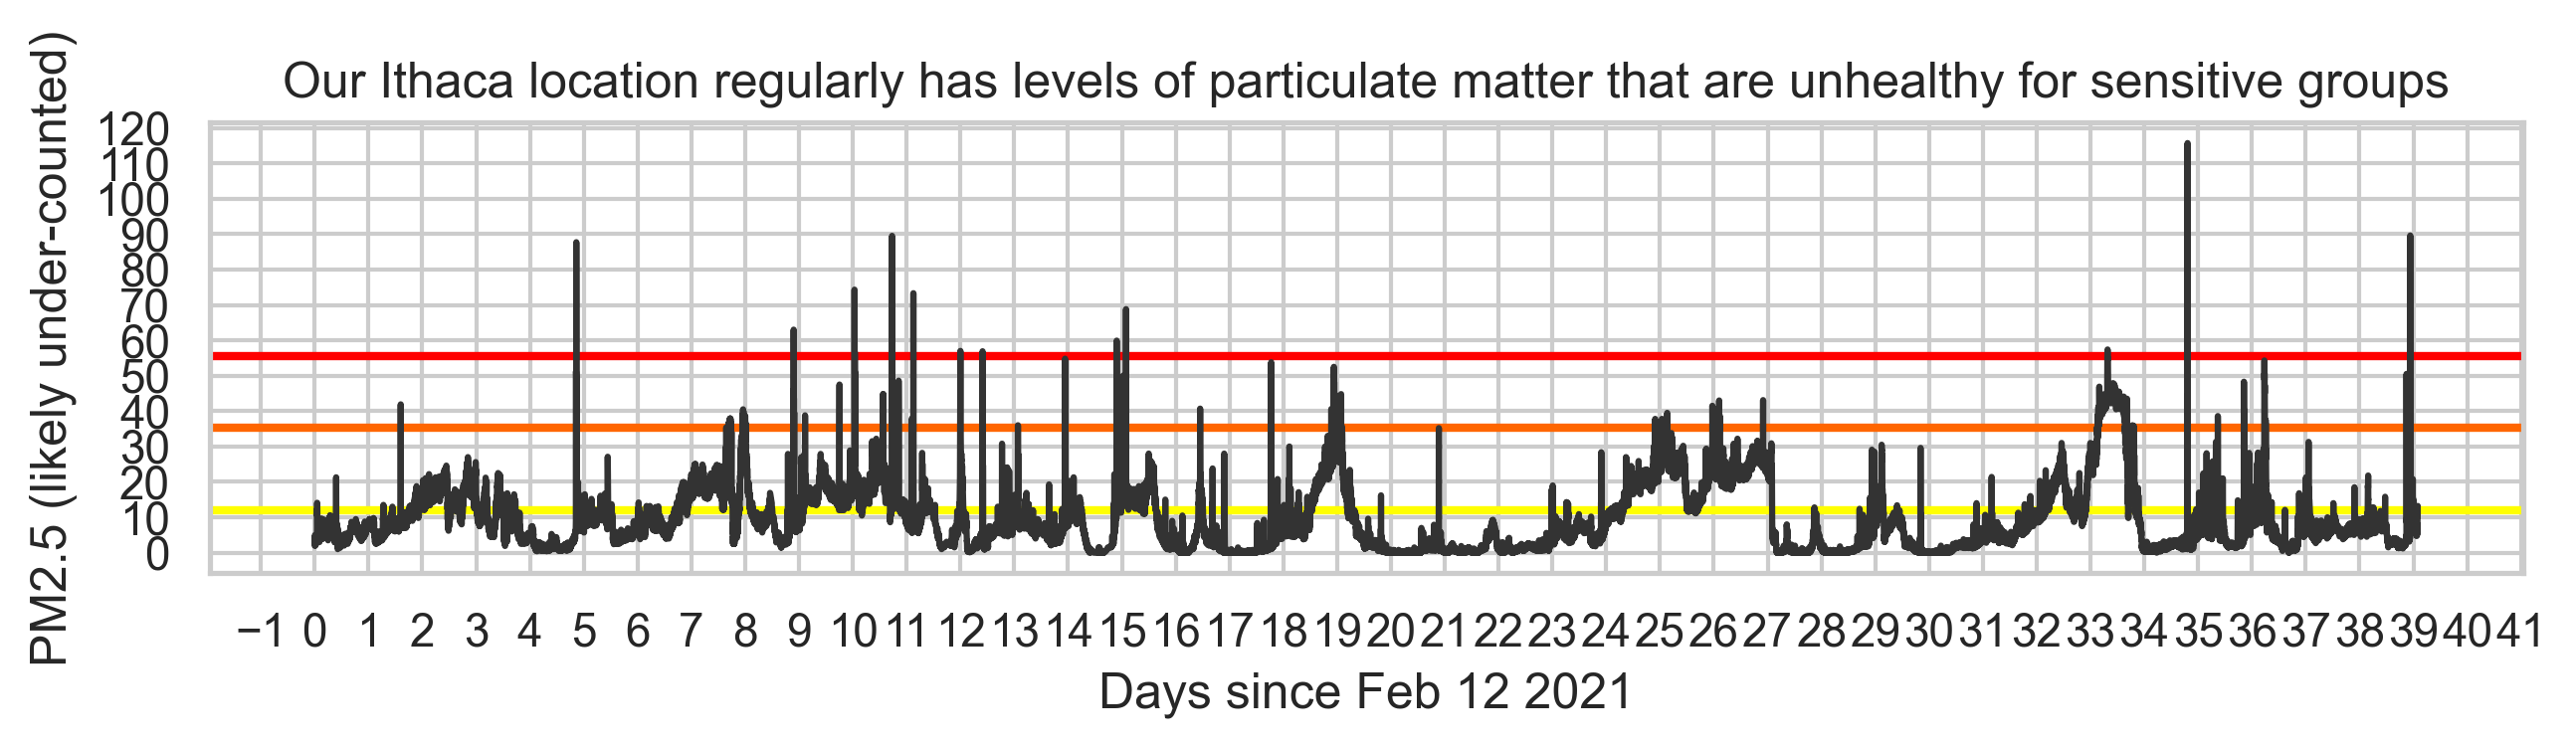

In [21]:
plt.figure(figsize=(10,2), dpi=300)
plt.axhline(y=12.1, color="#ffff00", linewidth=2)
plt.axhline(y=35.4, color="#ff6600", linewidth=2)
plt.axhline(y=55.4, color="#ff0000", linewidth=2)

ax = sns.lineplot(y=[x['pm2.5[ug/m^3]'] for x in middle_low.values() if x['pm2.5[ug/m^3]'] is not None],
                  x=[x['seconds_since_earliest']/86400 for x in middle_low.values() if x['pm2.5[ug/m^3]'] is not None], 
                 color="#333333")
sns.set_theme()
sns.set_style("whitegrid")
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(10))

plt.title("Our Ithaca location regularly has levels of particulate matter that are unhealthy for sensitive groups")
plt.ylabel("PM2.5 (likely under-counted)")
plt.xlabel("Days since Feb 12 2021")
plt.show()

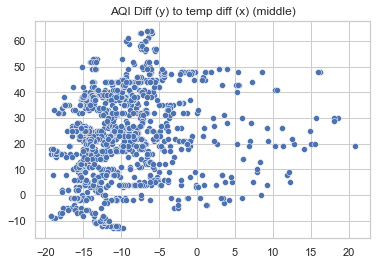

In [22]:
sns.scatterplot(y=[x['middle_west_aqi_diff'] for x in merged_measurements.values() if x['middle_west_aqi_diff'] is not None],
                x=[x['naive_temp_diff'] for x in merged_measurements.values() if x['middle_west_aqi_diff'] is not None])
plt.title("AQI Diff (y) to temp diff (x) (middle)")
plt.show()

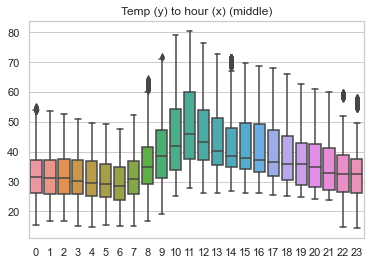

In [23]:
sns.boxplot(y=[x['middle_temperature[degF]'] for x in merged_measurements.values() if x['middle_temperature[degF]'] is not None],
               x=[x['middle_hour'] for x in merged_measurements.values() if x['middle_temperature[degF]'] is not None])
plt.title("Temp (y) to hour (x) (middle)")
plt.show()

In [24]:
# sns.scatterplot(y=[x['middle_aqi'] for x in merged_measurements.values() if x['middle_aqi'] is not None],
#                x=[x['middle_temperature[degF]'] for x in merged_measurements.values() if x['middle_aqi'] is not None])
# plt.title("AQI (y) to temp (x) (middle)")
# plt.show()

In [25]:
list(merged_measurements.values())[0].keys()

dict_keys(['middle_timestamp', 'middle_temperature[degF]', 'middle_humidity[%]', 'middle_co2[ppm]', 'middle_pm1.0[ug/m^3]', 'middle_pm2.5[ug/m^3]', 'middle_pm10.0[ug/m^3]', 'middle_pressure[Pa]', 'middle_altitude[m]', 'middle_aqi', 'middle_nowcast', 'middle_heatindex[degF]', 'middle_seconds_since_earliest', 'middle_seconds_since_last', 'east_timestamp', 'east_temperature[degF]', 'east_humidity[%]', 'east_co2[ppm]', 'east_pm1.0[ug/m^3]', 'east_pm2.5[ug/m^3]', 'east_pm10.0[ug/m^3]', 'east_pressure[Pa]', 'east_altitude[m]', 'east_aqi', 'east_nowcast', 'east_heatindex[degF]', 'east_seconds_since_earliest', 'east_seconds_since_last', 'seconds_since_east', 'west_timestamp', 'west_temperature[degF]', 'west_humidity[%]', 'west_co2[ppm]', 'west_pm1.0[ug/m^3]', 'west_pm2.5[ug/m^3]', 'west_pm10.0[ug/m^3]', 'west_pressure[Pa]', 'west_altitude[m]', 'west_aqi', 'west_nowcast', 'west_heatindex[degF]', 'west_seconds_since_earliest', 'west_seconds_since_last', 'seconds_since_west', 'wind_Timestamp', 'w

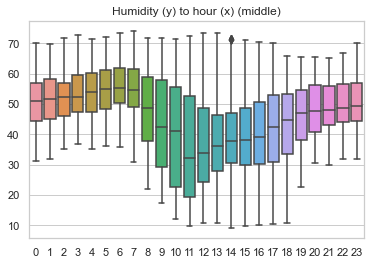

In [26]:
sns.boxplot(y=[x['middle_humidity[%]'] for x in merged_measurements.values() if x['middle_humidity[%]'] is not None],
               x=[x['middle_hour'] for x in merged_measurements.values() if x['middle_humidity[%]'] is not None])
plt.title("Humidity (y) to hour (x) (middle)")
plt.show()

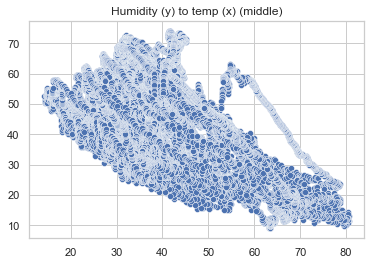

In [27]:
sns.scatterplot(y=[x['middle_humidity[%]'] for x in merged_measurements.values() if x['middle_humidity[%]'] is not None],
               x=[x['middle_temperature[degF]'] for x in merged_measurements.values() if x['middle_humidity[%]'] is not None])
plt.title("Humidity (y) to temp (x) (middle)")
plt.show()

## Create Exploratory and Confirmatory Datasets

In [28]:
## add another column
for row in merged_measurements.values():
    row['dark'] = row['middle_hour'] < 6 or row['middle_hour'] > 17

In [29]:
# random seed from https://www.brooklynintegers.com/int/1729924287/
random.seed(1729924287)

all_timestamps = set(merged_measurements.keys())
confirmatory_n = int(len(all_timestamps) *0.8)
exploratory_n  = len(all_timestamps) - confirmatory_n

confirmatory_timestamps = random.sample(list(all_timestamps), confirmatory_n)
exploratory_timestamps  = set(all_timestamps) - set(confirmatory_timestamps)

confirmatory_obs = [merged_measurements[x] for x in confirmatory_timestamps]
exploratory_obs = [merged_measurements[x] for x in exploratory_timestamps]

print("{0} in the confirmatory dataset".format(len(confirmatory_timestamps)))
print("{0} in the exploratory dataset".format(len(exploratory_timestamps)))

42588 in the confirmatory dataset
10647 in the exploratory dataset


## Statistical Models (exploratory)

In [30]:
exp_df = pd.DataFrame(exploratory_obs)

exp_df['middle_temp'] = exp_df['middle_temperature[degF]']
exp_df['middle_humidity'] = exp_df['middle_humidity[%]']

In [31]:
## basic model
res = smf.ols(formula = "middle_aqi ~ dark + middle_temp + naive_temp_diff + naive_inversion + wind_WS_ms__Avg", data=exp_df).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             middle_aqi   R-squared:                       0.245
Model:                            OLS   Adj. R-squared:                  0.241
Method:                 Least Squares   F-statistic:                     54.75
Date:                Sun, 06 Jun 2021   Prob (F-statistic):           2.65e-49
Time:                        10:21:41   Log-Likelihood:                -3722.2
No. Observations:                 849   AIC:                             7456.
Df Residuals:                     843   BIC:                             7485.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [32]:
## higher fit model
fitmodel = smf.ols(formula = "middle_aqi ~ middle_temp + middle_humidity + naive_temp_diff + middle_temp:middle_humidity + wind_WS_ms__Avg", data=exp_df).fit()
print(fitmodel.summary())

                            OLS Regression Results                            
Dep. Variable:             middle_aqi   R-squared:                       0.491
Model:                            OLS   Adj. R-squared:                  0.488
Method:                 Least Squares   F-statistic:                     162.2
Date:                Sun, 06 Jun 2021   Prob (F-statistic):          1.17e-120
Time:                        10:21:41   Log-Likelihood:                -3542.0
No. Observations:                 846   AIC:                             7096.
Df Residuals:                     840   BIC:                             7125.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

## Cross-Validate the Model

In [33]:
conf_df = pd.DataFrame(confirmatory_obs)

conf_df['middle_temp'] = conf_df['middle_temperature[degF]']
conf_df['middle_humidity'] = conf_df['middle_humidity[%]']

In [34]:
## higher fit model
confmodel = smf.ols(formula = "middle_aqi ~ middle_temp + middle_humidity + naive_temp_diff + middle_temp:middle_humidity + wind_WS_ms__Avg", data=conf_df).fit()
print(confmodel.summary())

                            OLS Regression Results                            
Dep. Variable:             middle_aqi   R-squared:                       0.468
Model:                            OLS   Adj. R-squared:                  0.467
Method:                 Least Squares   F-statistic:                     573.2
Date:                Sun, 06 Jun 2021   Prob (F-statistic):               0.00
Time:                        10:21:42   Log-Likelihood:                -13694.
No. Observations:                3267   AIC:                         2.740e+04
Df Residuals:                    3261   BIC:                         2.744e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

# Report the Overall Results

In [35]:
full_df = pd.DataFrame(merged_measurements.values())

full_df['middle_temp'] = full_df['middle_temperature[degF]']
full_df['middle_humidity'] = full_df['middle_humidity[%]']

In [36]:
## higher fit model
fitmodel = smf.ols(formula = "middle_aqi ~ middle_temp + middle_humidity + naive_temp_diff + middle_temp:middle_humidity + wind_WS_ms__Avg", data=full_df).fit()

print(fitmodel.summary())

                            OLS Regression Results                            
Dep. Variable:             middle_aqi   R-squared:                       0.472
Model:                            OLS   Adj. R-squared:                  0.471
Method:                 Least Squares   F-statistic:                     734.6
Date:                Sun, 06 Jun 2021   Prob (F-statistic):               0.00
Time:                        10:21:42   Log-Likelihood:                -17240.
No. Observations:                4113   AIC:                         3.449e+04
Df Residuals:                    4107   BIC:                         3.453e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

# How often have the conditions for serious problems occurred?

In [37]:
measurements_df = pd.DataFrame(merged_measurements.values())

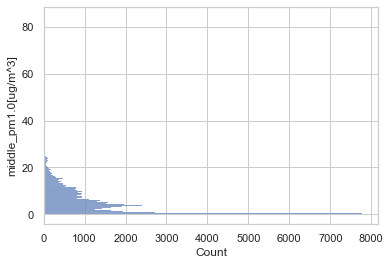

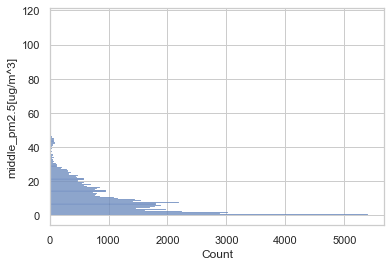

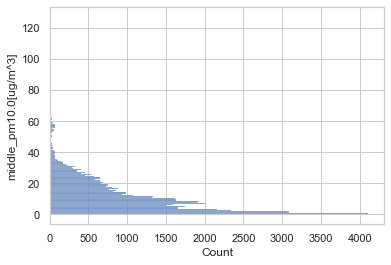

In [38]:
sns.histplot(y=measurements_df['middle_pm1.0[ug/m^3]'])
plt.show()

sns.histplot(y=measurements_df['middle_pm2.5[ug/m^3]'])
plt.show()

sns.histplot(y=measurements_df['middle_pm10.0[ug/m^3]'])
plt.show()

In [39]:
print("PM2.5 > 12")
print(Counter([x['middle_pm2.5[ug/m^3]']>12.1 and x['middle_pm2.5[ug/m^3]'] < 35.4 for x in merged_measurements.values() if x['middle_pm2.5[ug/m^3]'] is not None]))

print("PM2.5 > 35")
print(Counter([x['middle_pm2.5[ug/m^3]']>=35.4 and x['middle_pm2.5[ug/m^3]'] <55.4 for x in merged_measurements.values() if x['middle_pm2.5[ug/m^3]'] is not None]))

print("PM2.5 > 55.4")
print(Counter([x['middle_pm2.5[ug/m^3]']>=55.4 and x['middle_pm2.5[ug/m^3]'] < 150.4 for x in merged_measurements.values() if x['middle_pm2.5[ug/m^3]'] is not None]))

print("PM2.5 > 150.4")
print(Counter([x['middle_pm2.5[ug/m^3]']>=150.4 and x['middle_pm2.5[ug/m^3]'] < 250.4 for x in merged_measurements.values() if x['middle_pm2.5[ug/m^3]'] is not None]))

PM2.5 > 12
Counter({False: 37374, True: 14801})
PM2.5 > 35
Counter({False: 51193, True: 982})
PM2.5 > 55.4
Counter({False: 52148, True: 27})
PM2.5 > 150.4
Counter({False: 52175})


In [40]:
print("AQI over 30")
print(Counter([x['middle_aqi']>30 for x in merged_measurements.values() if x['middle_aqi'] is not None]))
print("AQI over 50")
print(Counter([x['middle_aqi']>50 for x in merged_measurements.values() if x['middle_aqi'] is not None]))

print("AQI over 100")
print(Counter([x['middle_aqi']>100 for x in merged_measurements.values() if x['middle_aqi'] is not None]))

AQI over 30
Counter({True: 2905, False: 2718})
AQI over 50
Counter({False: 3908, True: 1715})
AQI over 100
Counter({False: 5623})


In [41]:
Counter([x['naive_inversion'] for x in merged_measurements.values()])

Counter({True: 42649, None: 5211, False: 5375})

# How much worse are different places?

In [42]:
allergy_df = pd.DataFrame([x for x in merged_measurements.values() if x['middle_aqi'] is not None and x['middle_aqi']>30])
allergy_df['west_middle_aqi'] = allergy_df['west_aqi'] - allergy_df['middle_aqi']
allergy_df['east_middle_aqi'] = allergy_df['east_aqi'] - allergy_df['middle_aqi']

In [43]:
print("On days when we’re probably unwell at our apartment (AQI of 30 or higher), West side on average has a mean AQI that is {0} on average".format(np.mean(allergy_df['west_middle_aqi'])))

On days when we’re probably unwell at our apartment (AQI of 30 or higher), West side on average has a mean AQI that is -36.00204081632653 on average


In [44]:
print("On days when we’re probably unwell at our apartment (AQI of 30 or higher), East side on average has a mean AQI that is {0} on average".format(np.mean(allergy_df['east_middle_aqi'])))

On days when we’re probably unwell at our apartment (AQI of 30 or higher), East side on average has a mean AQI that is -17.0828025477707 on average
